# 1. Objetivo

## Problemática

El Tomato Yellow Leaf Curl Virus (TYLCV) es considerado una de las virosis más devastadoras del tomate a nivel global, generando pérdidas económicas significativas en la agricultura. Se estima que, incluso en regiones con buenas prácticas de manejo como Estados Unidos y Europa, el impacto del TYLCV puede suponer hasta un 20% de la producción anual, lo que representa cientos de millones de dólares en pérdidas. En zonas tropicales y subtropicales, donde las condiciones favorecen la propagación del vector, las infecciones pueden llegar a destruir el 100% de la cosecha en situaciones extremas (Glick et al., 2009; Yan et al., 2021).

Uno de los principales retos para el control del TYLCV es la detección temprana. Los síntomas visibles, como el amarilleo y rizado de hojas, pueden tardar hasta tres semanas en aparecer tras la infección, permitiendo así que el virus se disperse inadvertidamente entre los cultivos. Además, la transmisión eficiente por la mosca blanca Bemisia tabaci, sumada a la rápida adquisición y diseminación del virus, complica el manejo en campo. El uso intensivo de insecticidas tampoco es una solución sostenible, ya que la mosca blanca desarrolla resistencias y se refugia en malezas u otros cultivos, actuando como reservorio permanente del virus (Li et al., 2022; Yan et al., 2021).



La detección temprana y automatizada mediante imágenes y algoritmos de inteligencia artificial, especialmente modelos generativos como las GANs, representa una solución disruptiva para el problema. Mientras la inspección visual tradicional suele ser subjetiva y poco eficiente en grandes extensiones de cultivo, los sistemas automáticos pueden analizar grandes volúmenes de imágenes en tiempo real, identificando incluso señales sutiles o precoces de la infección. Los modelos GAN, en particular, permiten modelar el aspecto normal de la planta y resaltar anomalías producidas por el TYLCV, facilitando una intervención rápida antes de que el brote se generalice, incluso cuando hay pocos ejemplos de enfermedad etiquetada (Kaur, 2024; Yan et al., 2021).

## Objetivo del Proyecto

Entrenar un modelo generativo adversario (GAN) con imágenes de plantas de tomate sanas y con TYLCV para detectar automáticamente anomalías visuales indicativas de esta virosis en etapas iniciales. Se justifica el uso de GAN frente a clasificadores tradicionales porque este enfoque aprende a modelar la apariencia normal de la planta y puede destacar desviaciones sutiles causadas por el virus sin requerir un gran volumen de imágenes etiquetadas de enfermedad, lo que permite una identificación más temprana y flexible de nuevos casos.

# 2. Carga de los datos 

Las imágenes empleadas en este trabajo fueron extraídas del PlantVillage Dataset.
Siendo consistente con las indicaciones del repositorio original, se cita el siguiente artículo:

Mohanty, S. P., Hughes, D. P., & Salathé, M. (2016). Using deep learning for image-based plant disease detection. Frontiers in Plant Science, 7, 1419. https://doi.org/10.3389/fpls.2016.01419

# 3. Preparación de los Datos

### Librerias necesarias

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import seaborn as sns
import torch
from collections import Counter

### Redimencion y Normalizacion de imagenes


In [82]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),           # Redimensiona a 224x224
    transforms.ToTensor(),                   # Convierte a tensor y normaliza a [0, 1]
    transforms.Normalize([0.5]*3, [0.5]*3)   # Normaliza a [-1, 1] (opcional, recomendado para GANs)
])

dataset = ImageFolder(root="../data", transform=transform)

print(dataset.class_to_idx)
print(f"Total imágenes: {len(dataset)}")

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


{'anomaly': 0, 'healthy': 1}
Total imágenes: 4799


### Visualizacion inicial de los datos


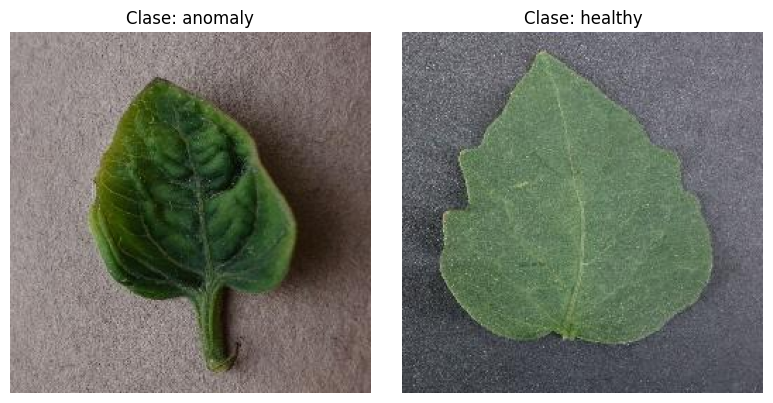

In [83]:

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

for idx, class_name in enumerate(dataset.classes):
    for i, (path, label) in enumerate(dataset.samples):
        if label == idx:
            img_path = path
            break
    img = plt.imread(img_path)
    axs[idx].imshow(img)
    axs[idx].set_title(f"Clase: {class_name}")
    axs[idx].axis('off')

plt.tight_layout()
plt.show()

Clase: anomaly - Cantidad de imágenes: 3208
Clase: healthy - Cantidad de imágenes: 1591


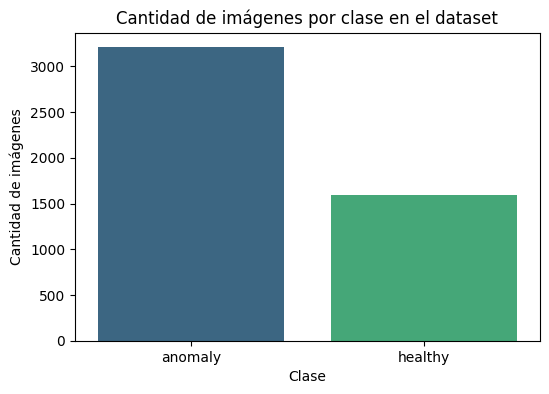

In [84]:
labels, counts = np.unique([label for _, label in dataset.samples], return_counts=True)
class_names = [dataset.classes[i] for i in labels]


for name, count in zip(class_names, counts):
    print(f"Clase: {name} - Cantidad de imágenes: {count}")

plt.figure(figsize=(6,4))
sns.barplot(x=class_names, y=counts, palette="viridis", hue=class_names, legend=False)
plt.title("Cantidad de imágenes por clase en el dataset")
plt.xlabel("Clase")
plt.ylabel("Cantidad de imágenes")
plt.show()

### Balancear data

#### Flujo correcto para balancear datos en deep learning

1. **Dividir el dataset original en train y test (por ejemplo, 80/20).**
2. **Balancear solo el DataLoader de entrenamiento** usando WeightedRandomSampler u otra técnica.
3. **El test set se deja con la distribución original** para evaluar el desempeño real del modelo.

Esto asegura que el modelo entrene de forma balanceada, pero se evalúe de forma realista.


#### Division de data

In [85]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

#### Balancear data de entrenamiento

In [86]:

train_targets = [dataset.samples[i][1] for i in train_dataset.indices]
class_sample_count = np.array([len(np.where(np.array(train_targets) == t)[0]) for t in np.unique(train_targets)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in train_targets])
samples_weight = torch.from_numpy(samples_weight).double()
sampler = WeightedRandomSampler(weights=samples_weight, num_samples=len(samples_weight), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Ver distribucion de clases

Distribución de clases en TRAIN:
Clase: anomaly - Cantidad: 2555
Clase: healthy - Cantidad: 1284

Distribución de clases en TEST:
Clase: anomaly - Cantidad: 653
Clase: healthy - Cantidad: 307


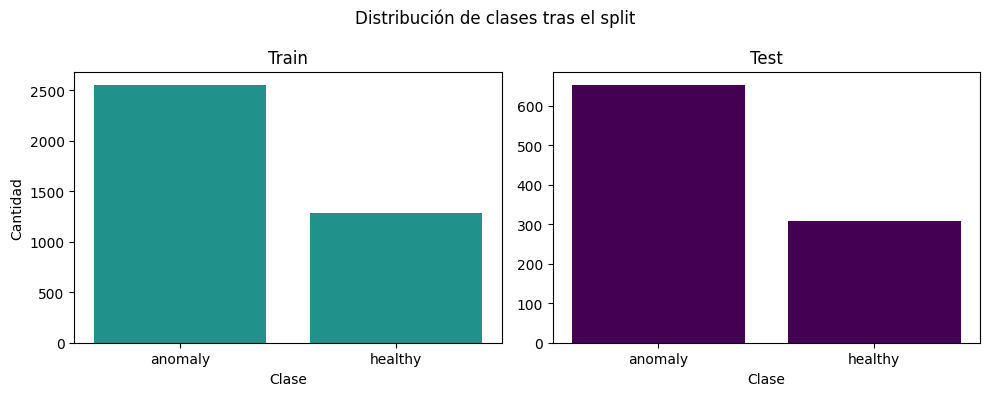

In [87]:

train_counts = np.bincount(train_targets)
test_targets = [dataset.samples[i][1] for i in test_dataset.indices]
test_counts = np.bincount(test_targets)
class_names = dataset.classes
print("Distribución de clases en TRAIN:")
for i, name in enumerate(class_names):
    print(f"Clase: {name} - Cantidad: {train_counts[i]}")
print("\nDistribución de clases en TEST:")
for i, name in enumerate(class_names):
    print(f"Clase: {name} - Cantidad: {test_counts[i]}")
    

fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].bar(class_names, train_counts, color="#21918c")
axs[0].set_title("Train")
axs[0].set_ylabel("Cantidad")
axs[1].bar(class_names, test_counts, color="#440154")
axs[1].set_title("Test")
for ax in axs:
    ax.set_xlabel("Clase")
plt.suptitle("Distribución de clases tras el split")
plt.tight_layout()
plt.show()
    



Distribución de clases en un batch balanceado de entrenamiento:
Clase: anomaly - Cantidad: 16
Clase: healthy - Cantidad: 16


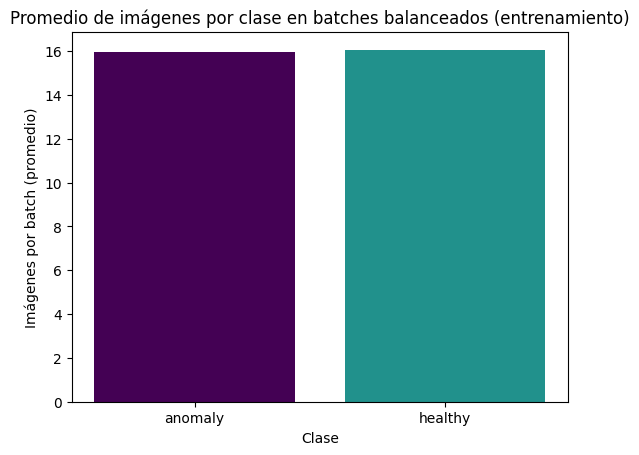

In [ ]:
num_batches = 50
distribucion = {name: [] for name in dataset.classes}
for _ in range(num_batches):
    batch = next(iter(train_loader))
    labels_batch = batch[1].numpy()
    unique, counts = np.unique(labels_batch, return_counts=True)
    for u, c in zip(unique, counts):
        distribucion[dataset.classes[u]].append(c)
        

batch = next(iter(train_loader))
labels_batch = batch[1].numpy()
unique, counts = np.unique(labels_batch, return_counts=True)
print("\nDistribución de clases en un batch balanceado de entrenamiento:")
for u, c in zip(unique, counts):
    print(f"Clase: {dataset.classes[u]} - Cantidad: {c}")


promedios = [np.mean(distribucion[name]) for name in dataset.classes]
plt.bar(dataset.classes, promedios, color=["#440154", "#21918c"])
plt.title("Promedio de imágenes por clase en batches balanceados (entrenamiento)")
plt.xlabel("Clase")
plt.ylabel("Imágenes por batch (promedio)")
plt.show()

# 4. Arquitectura del Modelo

# 5. Modelo GAN

# 6. Compilar el modelo GAN

# 7. Entrenar el modelo GAN

# 8. Predicción

# 9. Acciones